<a href="https://colab.research.google.com/github/zhangyumeng1sjtu/EPACT/blob/main/EPACT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EPACT Tutorial Notebook on Google Colab
| [Preprint](https://www.biorxiv.org/content/10.1101/2024.04.05.588255v1) | [GitHub](https://github.com/zhangyumeng1sjtu/EPACT/) |

EPACT is developed by a divide-and-conquer paradigm that combines pre-training on TCR or pMHC data and transfer learning to predict TCR$\alpha\beta$-pMHC binding specificity and interaction conformation via epitope-anchored contrastive learning.

In [1]:
%%time
#@title Install EPACT and Download model checkpoints

# Clone the GitHub Repo and install dependencies.
!git clone https://github.com/zhangyumeng1sjtu/EPACT.git
%cd EPACT
# !pip -q install torch==2.0.1 --index-url https://download.pytorch.org/whl/cu117
!pip -q install -r requirements.txt

# Download model checkpoints and data
!mkdir checkpoints
!wget -O checkpoints/EPACT-model-checkpoints.zip https://zenodo.org/records/10996150/files/EPACT-model-checkpoints.zip?download=1
%cd checkpoints
!unzip EPACT-model-checkpoints.zip > /dev/null 2>&1
%cd ..

!mkdir data
!wget -O data/EPACT-data.zip https://zenodo.org/records/10996150/files/EPACT-data.zip?download=1
%cd data
!unzip EPACT-data.zip > /dev/null 2>&1
%cd ..

Cloning into 'EPACT'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 72 (delta 19), reused 65 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 1.67 MiB | 23.46 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/EPACT
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━

## Predict Paired TCR-pMHC binding specificity.

Input Data Format: CSV files containing CDR3 (CDR1, CDR2) and Epitope sequences and MHC alleles.

| CDR3.alpha.aa | CDR3.beta.aa | Epitope.peptide | MHC | CDR1.alpha.aa | CDR2.alpha.aa | CDR1.beta.aa | CDR2.beta.aa |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| CAESVGKLIF | CSVGSQGTNEKLFF | GLCTLVAML | HLA-A*02:01 | DSSSTY | IFSNMDM | SQVTM | ANQGSEA |
|...|...|...|...|...|...|...|...|
| CVVNSINDYKLSF |CASSLTLQRVGTGELFF |  GLCTLVAML | HLA-A*02:01 | NSASQS | VYSSGN | SGHTA | FQGNSA |

Model Options:
  - `checkpoints/paired-cdr3-pmhc-binding`: predict TCR$\alpha\beta$-pMHC binding specificity from CDR3 sequences.
  - `checkpoints/paired-cdr123-pmhc-binding`: predict TCR$\alpha\beta$-pMHC binding specificity from CDR1, CDR2, and CDR3 sequences.



In [2]:
#@title Run prediction

import os

from torch.utils.data import DataLoader
from EPACT.utils import load_config, set_seed
from EPACT.dataset import UnlabeledDataset, UnlabeledBacthConverter
from EPACT.trainer import PairedCDR3pMHCCoembeddingTrainer, PairedCDR123pMHCCoembeddingTrainer

#@markdown Select the EPACT model:
model_name = "CDR123 binding model" #@param ['CDR3 binding model', 'CDR123 binding model']

#@markdown In default, we will use `sample/VDJdb-GLCTLVAML.csv` for prediction.
input_data_path = "sample/VDJdb-GLCTLVAML.csv" #@param {type:"string"}

#@markdown Specify the name of the result folder:
result_dir = "demo/binding" #@param {type:"string"}

#@markdown Specify the number of batch size:
batch_size = 128 #@param {type: "integer"}


if model_name == "CDR3 binding model":
  config_path = 'configs/config-paired-cdr3-pmhc-binding.yml'
  model_location_list = [f'checkpoints/paired-cdr3-pmhc-binding/paired-cdr3-pmhc-binding-model-fold-{i+1}.pt' for i in range(5)]
elif model_name == "CDR123 binding model":
  config_path = 'configs/config-paired-cdr123-pmhc-binding.yml'
  model_location_list = [f'checkpoints/paired-cdr123-pmhc-binding/paired-cdr123-pmhc-binding-model-fold-{i+1}.pt' for i in range(5)]

config = load_config(config_path)
set_seed(config.training.seed)
config.training.gpu_device = 0


dataset = UnlabeledDataset(data_path = input_data_path, hla_lib_path = config.data.hla_lib_path)
data_loader = DataLoader(
        dataset = dataset, batch_size = batch_size, num_workers = 1,
        collate_fn = UnlabeledBacthConverter(max_mhc_len = config.model.mhc_seq_len, use_cdr123=config.data.use_cdr123),
        shuffle = False
    )

if not os.path.exists(result_dir):
  os.makedirs(result_dir)

for i in range(5):
  result_fold_dir = os.path.join(result_dir, f'Fold_{i+1}')

  if not os.path.exists(result_fold_dir):
    os.makedirs(result_fold_dir)

  if config.data.use_cdr123:
      Trainer = PairedCDR123pMHCCoembeddingTrainer(config, result_fold_dir)
  else:
      Trainer = PairedCDR3pMHCCoembeddingTrainer(config, result_fold_dir)

  Trainer.predict(data_loader, model_location=model_location_list[i])


  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2/2 [00:00<00:00,  3.83it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and J

In [3]:
#@title Display prediction results
import pandas as pd

data = pd.read_csv(input_data_path)
for i in range(5):
  prediction = pd.read_csv(f'{result_dir}/Fold_{i+1}/predictions.csv')
  if i == 0:
    avg_pred = prediction['Pred'] / 5
  else:
    avg_pred += prediction['Pred'] / 5

data['Pred'] = avg_pred
data

,CDR3.alpha.aa,CDR3.beta.aa,Epitope.peptide,MHC,V.alpha,J.alpha,V.beta,J.beta,CDR1.alpha.aa,CDR2.alpha.aa,CDR1.beta.aa,CDR2.beta.aa,Target,Pred
0,CAESVGKLIF,CSVGSQGTNEKLFF,GLCTLVAML,HLA-A*02:01,TRAV5,TRAJ23,TRBV29-1,TRBJ1-4,DSSSTY,IFSNMDM,SQVTM,ANQGSEA,1,0.807142
1,CAFVANAGGTSYGKLTF,CASSYTRVNEQFF,GLCTLVAML,HLA-A*02:01,TRAV38-1,TRAJ52,TRBV6-9,TRBJ2-1,TSENNYY,QEAYKQQN,MNHGY,SVAAGI,1,0.020218
2,CAGNNARLVF,CASSQSPGGTQYF,GLCTLVAML,HLA-A*02:01,TRAV27,TRAJ31,TRBV14,TRBJ2-5,SVFSS,VVTGGEV,SGHDN,FVKESK,1,0.016683
3,CAGNNARPMF,CASSQSPGGVAFF,GLCTLVAML,HLA-A*02:01,TRAV27,TRAJ31,TRBV14,TRBJ1-1,SVFSS,VVTGGEV,SGHDN,FVKESK,1,0.009218
4,CALDILYNQGGKLIF,CASSQSPGGTQYF,GLCTLVAML,HLA-A*02:01,TRAV6,TRAJ23,TRBV14,TRBJ2-5,NYSPAY,IRENEKE,SGHDN,FVKESK,1,0.120138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,CAVNGNNNDMRF,CASAWGGMTNEQYF,GLCTLVAML,HLA-A*02:01,TRAV12-2,TRAJ43,TRBV19,TRBJ2-7,DRGSQS,IYSNGD,LNHDA,SQIVND,0,0.004454
224,CAAPTGFGNEKLTF,CASSSGLAGVETGELFF,GLCTLVAML,HLA-A*02:01,TRAV29/DV5,TRAJ48,TRBV5-1,TRBJ2-2,NSMFDY,ISSIKDK,SGHRS,YFSETQ,0,0.006342
225,CAYIIIQGAQKLVF,CASSLSAVHGYTF,GLCTLVAML,HLA-A*02:01,TRAV38-1,TRAJ54,TRBV27,TRBJ1-2,TSENNYY,QEAYKQQN,MNHEY,SMNVEV,0,0.059761
226,CLVTGSARQLTF,CASSQEQGGWGEQYF,GLCTLVAML,HLA-A*02:01,TRAV4,TRAJ22,TRBV4-2,TRBJ2-7,NIATNDY,GYKTK,LGHNA,YNFKEQ,0,0.079494


## Predict Paired TCR-pMHC Residual-level Interactions

Input Data Format: CSV files containing CDR1, CDR2, CDR3, and Epitope sequences and MHC alleles.

| CDR3.alpha.aa | CDR3.beta.aa | Epitope.peptide | MHC | CDR1.alpha.aa | CDR2.alpha.aa | CDR1.beta.aa | CDR2.beta.aa |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| CAVQKLVF | CASSYSFTEATYEQYF | EAAGIGILTV | HLA-A*02:01 | DRGSQS | IYSNGD | MNHEY | SVGAGI |
|...|...|...|...|...|...|...|...|
| CAVNVAGKSTF	| CAWSETGLGTGELFF	| NLSALGIFST | HLA-A*02:01 | DRGSQS | IYSNGD | GTSNPN	| SVGIG |

Model Options:
- `checkpoints/paired-cdr123-pmhc-interaction`: predict CDR-epitope residue-level distance matrix and contact sites.


In [4]:
#@title Run prediction

import os

from torch.utils.data import DataLoader
from EPACT.utils import load_config, set_seed
from EPACT.dataset import UnlabeledDataset, UnlabeledBacthConverter
from EPACT.trainer import PairedCDR123pMHCInteractTrainer

#@markdown In default, we will use `sample/TCR-cross-reactivity-MEL8.csv` for inteaction prediction.
input_data_path = "sample/TCR-cross-reactivity-MEL8.csv" #@param {type:"string"}

#@markdown Specify the name of the result folder:
result_dir = "demo/interaction" #@param {type:"string"}

#@markdown Specify the number of batch size:
batch_size = 1 #@param {type: "integer"}

config_path = 'configs/config-paired-cdr123-pmhc-interact.yml'
model_location = 'checkpoints/paired-cdr123-pmhc-interaction/paired-cdr123-pmhc-interaction-model-all.pt'

config = load_config(config_path)
set_seed(config.training.seed)
config.training.gpu_device = 0

dataset = UnlabeledDataset(data_path = input_data_path, hla_lib_path = config.data.hla_lib_path)
data_loader = DataLoader(
        dataset = dataset, batch_size = batch_size, num_workers = 1,
        collate_fn = UnlabeledBacthConverter(max_mhc_len = config.model.mhc_seq_len, use_cdr123=config.data.use_cdr123),
        shuffle = False
    )

if not os.path.exists(result_dir):
  os.makedirs(result_dir)


Trainer = PairedCDR123pMHCInteractTrainer(config, result_dir)

Trainer.predict(data_loader, model_location=model_location)


  0%|          | 0/6 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 17%|█▋        | 1/6 [00:00<00:01,  3.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 6/6 [00:00<00:00, 14.09it/s]


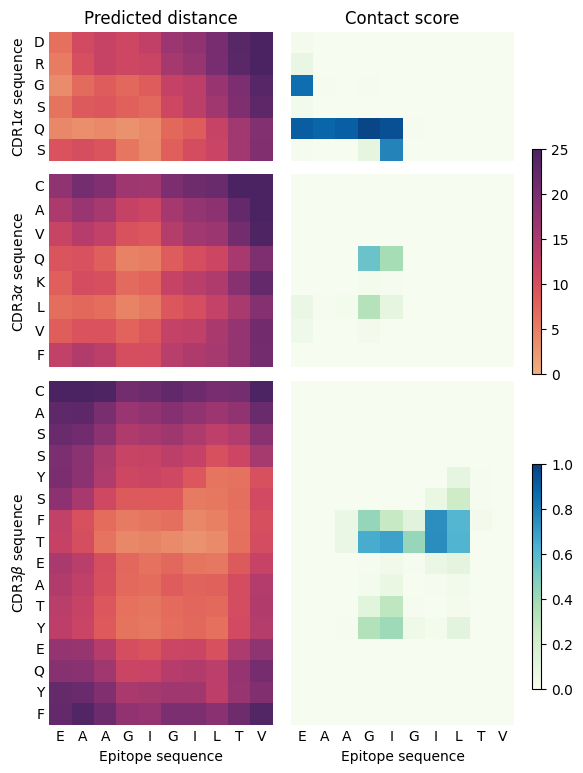

In [5]:
#@title Display prediction results
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

prediction_path = f'{result_dir}/predictions.pkl'
with open(prediction_path, 'rb') as f:
    predictions = pickle.load(f)

plot_data = predictions[0]

fig, axes = plt.subplots(3, 2, figsize=(6, 9), sharey='row', sharex='col', gridspec_kw={
                         'wspace': 0.08, 'hspace': 0.06, 'height_ratios': [0.6, 0.9, 1.6]})
epitope = plot_data['epitope']
cdr1_alpha = plot_data['cdr1.alpha']
cdr3_alpha = plot_data['cdr3.alpha']
cdr3_beta = plot_data['cdr3.beta']

sns.heatmap(plot_data['dist']['cdr1.alpha'],
            cmap='flare', vmin=0, vmax=25, ax=axes[0, 0], cbar=False)
axes[0, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[0, 0].set_yticks(np.arange(len(cdr1_alpha))+0.5,
                      labels=list(cdr1_alpha), rotation=0)
axes[0, 0].set_title(r'Predicted distance')
axes[0, 0].set_ylabel(r'CDR1$\alpha$ sequence')

sns.heatmap(plot_data['contact']['cdr1.alpha'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[0, 1], cbar=False)
axes[0, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[0, 1].set_yticks(np.arange(len(cdr1_alpha))+0.5,
                     labels=list(cdr1_alpha), rotation=0)
axes[0, 1].set_title(r'Contact score')

sns.heatmap(plot_data['dist']['cdr3.alpha'],
            cmap='flare', vmin=0, vmax=25, ax=axes[1, 0], cbar=False)
axes[1, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[1, 0].set_yticks(np.arange(len(cdr3_alpha))+0.5,
                      labels=list(cdr3_alpha), rotation=0)
axes[1, 0].set_ylabel(r'CDR3$\alpha$ sequence')

sns.heatmap(plot_data['contact']['cdr3.alpha'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[1, 1], cbar=False)
axes[1, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[1, 1].set_yticks(np.arange(len(cdr3_alpha))+0.5,
                      labels=list(cdr3_alpha), rotation=0)

sns.heatmap(plot_data['dist']['cdr3.beta'],
            cmap='flare', vmin=0, vmax=25, ax=axes[2, 0], cbar=False)
axes[2, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[2, 0].set_yticks(np.arange(len(cdr3_beta))+0.5,
                      labels=list(cdr3_beta), rotation=0)
axes[2, 0].set_xlabel('Epitope sequence')
axes[2, 0].set_ylabel(r'CDR3$\beta$ sequence')

sns.heatmap(plot_data['contact']['cdr3.beta'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[2, 1], cbar=False)
axes[2, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[2, 1].set_yticks(np.arange(len(cdr3_beta))+0.5,
                      labels=list(cdr3_beta), rotation=0)
axes[2, 1].set_xlabel('Epitope sequence')

axes[0, 0].tick_params(axis='both', which='both', length=0)
axes[0, 1].tick_params(axis='both', which='both', length=0)
axes[1, 0].tick_params(axis='both', which='both', length=0)
axes[1, 1].tick_params(axis='both', which='both', length=0)
axes[2, 0].tick_params(axis='both', which='both', length=0)
axes[2, 1].tick_params(axis='both', which='both', length=0)

# [left, bottom, width, height]
cbar_ax_1 = fig.add_axes([0.93, 0.5, 0.015, 0.25])
plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax_1)

cbar_ax_2 = fig.add_axes([0.93, 0.15, 0.015, 0.25])
plt.colorbar(axes[0, 1].collections[0], cax=cbar_ax_2)

plt.show()